# Laboratory 3 homework

Homework is the preparation of NYC taxi data for demand forecasting, implemented
as regression-based time series forecasting. The goal is to predict the daily
number of taxi rides in the future, based on historical features. This requires
building a full data engineering pipeline: reading, cleaning, transforming, and
extracting features.

In [58]:
import polars as pl
from datetime import date

1. Data reading
   - load all 2024 months of taxi rides
   - also load taxi zone lookup data
   - include only rides starting in 2024 and ending at most at 01.01.2025
   - optimize data types, particularly for integers and categorical strings

In [59]:
df_taxi_zones = pl.scan_csv("data/taxi_zone_lookup.csv")
df_taxi_zones.collect()

LocationID,Borough,Zone,service_zone
i64,str,str,str
1,"""EWR""","""Newark Airport""","""EWR"""
2,"""Queens""","""Jamaica Bay""","""Boro Zone"""
3,"""Bronx""","""Allerton/Pelham Gardens""","""Boro Zone"""
4,"""Manhattan""","""Alphabet City""","""Yellow Zone"""
5,"""Staten Island""","""Arden Heights""","""Boro Zone"""
…,…,…,…
261,"""Manhattan""","""World Trade Center""","""Yellow Zone"""
262,"""Manhattan""","""Yorkville East""","""Yellow Zone"""
263,"""Manhattan""","""Yorkville West""","""Yellow Zone"""


In [60]:
# load all 2024 months of taxi rides
DATA_DIR = "data"
dfs = []
for month in range(1, 13):
    df = pl.scan_parquet(f"{DATA_DIR}/{month}.parquet")
    df = df.with_columns(
        pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
        pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
    )
    dfs.append(df)

df: pl.LazyFrame = pl.concat(dfs)

# include only rides starting in 2024 and ending at most at 01.01.2025
df = df.filter(
    pl.col("tpep_pickup_datetime")
    .dt.date()
    .is_in(
        pl.date_range(
            date(2024, 1, 1),
            date(2025, 1, 1),
        )
    )
)

# optimize data types, particularly for integers and categorical strings
df = df.with_columns(
    pl.col("passenger_count").cast(pl.UInt8),
    pl.col("payment_type").cast(pl.UInt8),
    pl.col("RatecodeID").cast(pl.UInt8),
    pl.col("PULocationID").cast(pl.UInt16),
    pl.col("DOLocationID").cast(pl.UInt16),
    pl.col("store_and_fwd_flag").cast(pl.Enum(["N", "Y"])),
)

df.collect_schema()

Schema([('VendorID', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('RatecodeID', UInt8),
        ('store_and_fwd_flag', Enum(categories=['N', 'Y'])),
        ('PULocationID', UInt16),
        ('DOLocationID', UInt16),
        ('payment_type', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('Airport_fee', Float64)])

2. Data cleaning and filtering
   - fill NULL values in `passengers_count` with 1
   - remove rides with zero passengers
   - if a ride has over 6 passengers, replace the value with 6
   - remove rides lasting over 2 hours
   - in all money-related columns, replace values with absolute value to fix
     negative amounts
   - remove rides with over 1000 dollars in any money-related column
   - remove rows with values of `RatecodeID` or `VendorID` missing or outside
     those defined in the data dictionary

In [61]:
money_columns = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
]

df = (
    df.with_columns(pl.col("passenger_count").fill_null(1))
    .filter(pl.col("passenger_count") != 0)
    .with_columns(pl.col("passenger_count").clip(upper_bound=6))
    .filter((pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_hours() < 2)
    .with_columns(pl.col(col).abs() for col in money_columns)
    .filter(pl.col(col) < 1_000 for col in money_columns)
    .filter(
        pl.col("RatecodeID").is_in([1, 2, 3, 4, 5, 6, 99]),
        pl.col("VendorID").is_in([1, 2, 6, 7]),
    )
)

df.collect_schema()

Schema([('VendorID', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('RatecodeID', UInt8),
        ('store_and_fwd_flag', Enum(categories=['N', 'Y'])),
        ('PULocationID', UInt16),
        ('DOLocationID', UInt16),
        ('payment_type', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('Airport_fee', Float64)])

3. Data transformation
   - combine payment type values for `"No charge"`, `"Dispute"`, `"Unknown"` and
     `"Voided trip"` into one type, so we have only credit card, cash, or other
   - replace `PULocationID` and `DOLocationID` with borough names by joining
     taxi zone lookup and removing unnecessary columns
   - add boolean variable `is_airport_ride`, true if there is non-zero airport
     fee
   - add boolean variable `is_rush_hour`, rush hours are defined as 6:30–9:30
     and 15:30-20:00 during weekdays

In [62]:
df = (
    df.with_columns(pl.col("payment_type").replace({0: 3, 3: 3, 4: 3, 5: 3, 6: 3}))
    .join(df_taxi_zones, left_on="PULocationID", right_on="LocationID")
    .rename({"Borough": "PUBorough", "Zone": "PUZone", "service_zone": "PU_service_zone"})
    .join(df_taxi_zones, left_on="DOLocationID", right_on="LocationID")
    .rename({"Borough": "DOBorough", "Zone": "DOZone", "service_zone": "DO_service_zone"})
    .drop("PULocationID", "DOLocationID", "PUZone", "PU_service_zone", "DOZone", "DO_service_zone")
    .with_columns((pl.col("Airport_fee") > 0).alias("is_airport_ride"))
    .with_columns(
        (
            pl.col("tpep_pickup_datetime").dt.time().is_between(pl.time(6, 30), pl.time(9, 30))
            | pl.col("tpep_pickup_datetime").dt.time().is_between(pl.time(15, 30), pl.time(20, 0))
        ).alias("is_rush_hour")
    )
)

df.collect_schema()

Schema([('VendorID', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('RatecodeID', UInt8),
        ('store_and_fwd_flag', Enum(categories=['N', 'Y'])),
        ('payment_type', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('Airport_fee', Float64),
        ('PUBorough', String),
        ('DOBorough', String),
        ('is_airport_ride', Boolean),
        ('is_rush_hour', Boolean)])

4. Feature extraction
   - apply dummy encoding to features:
     - payment type
     - pickup borough
     - dropoff borough
   - add integer variables for counting daily events:
     - total number of rides (target variable)
     - number of airport rides
     - number of rush hour rides
   - add features aggregating daily rides information:
     - average fare amount
     - median distance
     - sum of total amounts
     - total amount paid by card, cash, and other
     - total congestion surcharge
     - total number of passengers
   - add time features:
     - `quarter`
     - `month`
     - `day_of_month`
     - `day_of_week`
     - `is_weekend` (boolean)
   - add column `date`, indicating day with given features
   - make sure to exclude other columns, unnecessary for machine learning, e.g.
     IDs, timestamps, unused financial information
   - properly name all columns
   - save results as `dataset.parquet` file

In [63]:
df = (
    df.collect()
    .to_dummies(columns=["payment_type", "PUBorough", "DOBorough"])
    .lazy()
    .with_columns(
        pl.col("tpep_pickup_datetime").dt.ordinal_day().alias("day_of_year"),
        pl.col("tpep_pickup_datetime").dt.quarter().alias("quarter"),
        pl.col("tpep_pickup_datetime").dt.month().alias("month"),
        pl.col("tpep_pickup_datetime").dt.day().alias("day_of_month"),
        pl.col("tpep_pickup_datetime").dt.weekday().alias("day_of_week"),
        (pl.col("tpep_pickup_datetime").dt.weekday() > 5).alias("is_weekend"),
        pl.col("tpep_pickup_datetime").dt.date().alias("date"),
    )
    .group_by(
        "date",
        "day_of_year",
        "quarter",
        "month",
        "day_of_month",
        "day_of_week",
        "is_weekend",
    )
    .agg(
        pl.col("VendorID").count().alias("number_of_rides"),
        pl.col("VendorID").filter("is_airport_ride").count().alias("number_of_airport_rides"),
        pl.col("VendorID").filter("is_rush_hour").count().alias("number_of_rush_hour_rides"),
        pl.col("fare_amount").mean().alias("avg_fare_amount"),
        pl.col("trip_distance").median().alias("median_trip_dist"),
        pl.col("total_amount").sum().alias("sum_total_amount"),
        pl.col("payment_type_1").sum().alias("tot_amount_card"),
        pl.col("payment_type_2").sum().alias("tot_amount_cash"),
        pl.col("payment_type_3").sum().alias("tot_amount_other"),
        pl.col("congestion_surcharge").sum().alias("tot_congestion_surcharge"),
        pl.col("passenger_count").sum().alias("tot_num_of_passengers"),
    )
    .sort("date")
    .collect()
)

df

date,day_of_year,quarter,month,day_of_month,day_of_week,is_weekend,number_of_rides,number_of_airport_rides,number_of_rush_hour_rides,avg_fare_amount,median_trip_dist,sum_total_amount,tot_amount_card,tot_amount_cash,tot_amount_other,tot_congestion_surcharge,tot_num_of_passengers
date,i16,i8,i8,i8,i8,bool,u32,u32,u32,f64,f64,f64,i64,i64,i64,f64,i64
2024-01-01,1,1,1,1,1,false,69665,8352,19398,22.217628,2.09,2.1849e6,52970,14491,2204,156123.25,109137
2024-01-02,2,1,1,2,2,false,72583,9828,31014,21.501448,1.82,2.2501e6,55174,15387,2022,160615.0,104071
2024-01-03,3,1,1,3,3,false,79566,9140,33389,20.170854,1.75,2.3320e6,61343,16202,2021,177985.0,110973
2024-01-04,4,1,1,4,4,false,99077,8270,43572,18.866102,1.75,2.7604e6,78738,17994,2345,226627.5,135815
2024-01-05,5,1,1,5,5,false,98860,7460,40518,18.246814,1.7,2.6767e6,78701,17699,2460,227542.5,137166
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-27,362,4,12,27,5,false,80178,7275,30563,21.296792,1.77,2.4533e6,60366,15878,3934,181365.0,122594
2024-12-28,363,4,12,28,6,true,82228,6848,30180,20.321744,1.7,2.3507e6,60840,17306,4082,187202.5,128555
2024-12-29,364,4,12,29,7,true,74069,7751,26237,22.271538,1.92,2.2984e6,55364,14601,4104,165090.0,115296


In [64]:
df.write_parquet("data/dataset.parquet")

5. Data analysis
   - print shape
   - show top rows
   - describe statistics
   - print schema
   - plot target variable (daily number of rides):
     - histogram of values
     - line plot, date vs number of rides (remember to sort by date)

In [65]:
df.shape

(366, 18)

In [66]:
df.head()

date,day_of_year,quarter,month,day_of_month,day_of_week,is_weekend,number_of_rides,number_of_airport_rides,number_of_rush_hour_rides,avg_fare_amount,median_trip_dist,sum_total_amount,tot_amount_card,tot_amount_cash,tot_amount_other,tot_congestion_surcharge,tot_num_of_passengers
date,i16,i8,i8,i8,i8,bool,u32,u32,u32,f64,f64,f64,i64,i64,i64,f64,i64
2024-01-01,1,1,1,1,1,false,69665,8352,19398,22.217628,2.09,2.1849e6,52970,14491,2204,156123.25,109137
2024-01-02,2,1,1,2,2,false,72583,9828,31014,21.501448,1.82,2.2501e6,55174,15387,2022,160615.0,104071
2024-01-03,3,1,1,3,3,false,79566,9140,33389,20.170854,1.75,2.3320e6,61343,16202,2021,177985.0,110973
2024-01-04,4,1,1,4,4,false,99077,8270,43572,18.866102,1.75,2.7604e6,78738,17994,2345,226627.5,135815
2024-01-05,5,1,1,5,5,false,98860,7460,40518,18.246814,1.7,2.6767e6,78701,17699,2460,227542.5,137166


In [67]:
df.describe()

statistic,date,day_of_year,quarter,month,day_of_month,day_of_week,is_weekend,number_of_rides,number_of_airport_rides,number_of_rush_hour_rides,avg_fare_amount,median_trip_dist,sum_total_amount,tot_amount_card,tot_amount_cash,tot_amount_other,tot_congestion_surcharge,tot_num_of_passengers
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""366""",366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2024-07-01 12:00:00""",183.5,2.505464,6.513661,15.756831,3.986339,0.284153,100097.636612,8978.31694,39030.956284,19.952214,1.718661,2.9111e6,82241.863388,14923.740437,2932.032787,230206.340219,134961.898907
"""std""",null,105.799338,1.119551,3.455958,8.823592,2.006108,null,15370.166176,1715.373815,7587.986427,1.204214,0.100882,461378.000255,14159.433211,1357.289241,554.549847,37860.875179,18722.583934
"""min""","""2024-01-01""",1.0,1.0,1.0,1.0,1.0,0.0,47390.0,3355.0,17240.0,16.676264,1.5,1.3260e6,34052.0,10244.0,1656.0,107825.0,74198.0
"""25%""","""2024-04-01""",92.0,2.0,4.0,8.0,2.0,null,89572.0,7869.0,33332.0,19.125929,1.66,2.5818e6,72543.0,14109.0,2566.0,203501.0,122219.0
"""50%""","""2024-07-02""",184.0,3.0,7.0,16.0,4.0,null,100781.0,9018.0,40206.0,19.950719,1.7,2.9164e6,83419.0,14966.0,2910.0,232817.5,134078.0
"""75%""","""2024-10-01""",275.0,4.0,10.0,23.0,6.0,null,110799.0,10144.0,44782.0,20.713722,1.77,3.2228e6,91738.0,15833.0,3271.0,256939.5,147187.0
"""max""","""2024-12-31""",366.0,4.0,12.0,31.0,7.0,1.0,141676.0,14903.0,56567.0,24.447593,2.2,4.4620e6,120976.0,17994.0,4596.0,330475.0,199440.0


In [68]:
df.schema

Schema([('date', Date),
        ('day_of_year', Int16),
        ('quarter', Int8),
        ('month', Int8),
        ('day_of_month', Int8),
        ('day_of_week', Int8),
        ('is_weekend', Boolean),
        ('number_of_rides', UInt32),
        ('number_of_airport_rides', UInt32),
        ('number_of_rush_hour_rides', UInt32),
        ('avg_fare_amount', Float64),
        ('median_trip_dist', Float64),
        ('sum_total_amount', Float64),
        ('tot_amount_card', Int64),
        ('tot_amount_cash', Int64),
        ('tot_amount_other', Int64),
        ('tot_congestion_surcharge', Float64),
        ('tot_num_of_passengers', Int64)])

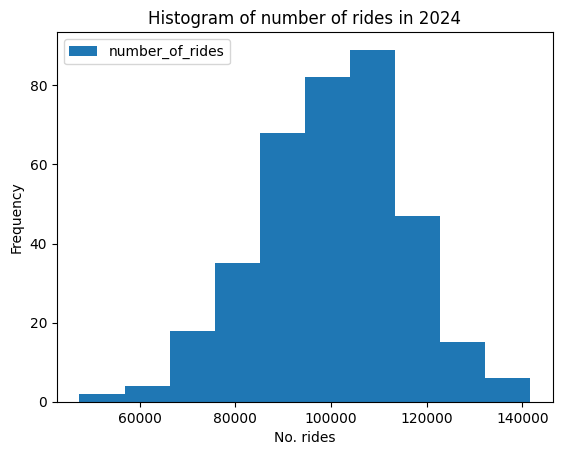

In [76]:
(
    df.select("number_of_rides")
    .to_pandas()
    .plot.hist(
        xlabel="No. rides",
        title="Histogram of number of rides in 2024",
    )
);

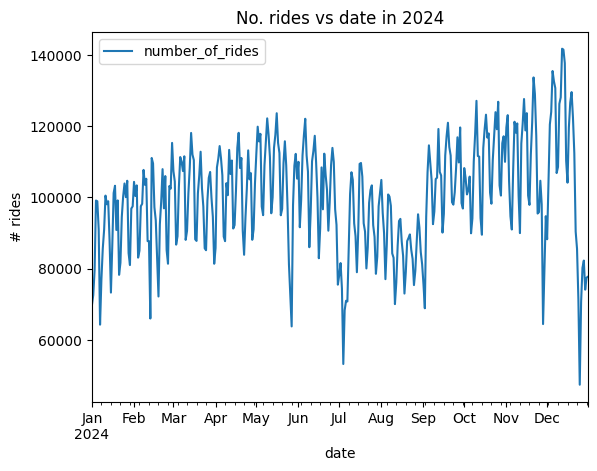

In [79]:
(
    df.select("date", "number_of_rides")
    .sort("date")
    .to_pandas()
    .plot.line(
        x="date",
        y="number_of_rides",
        ylabel="# rides",
        title="No. rides vs date in 2024",
    )
);